In [1]:
import json
import os
import time
import ipyparallel as ipp

import matplotlib.pyplot as plt
import torch
import dfca as DFCA
import ifca as IFCA

import numpy as np

from util import *

Reads Config file and prepares the arguments you can choose in the config_dfca.json/config_ifca.json

In [2]:
rc = ipp.Cluster(n=3).start_and_connect_sync()
rc.activate()

rc.ids 

dview = rc[:]

Starting 3 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/3 [00:00<?, ?engine/s]

In [3]:
learning_rates = [0.1]

dfca_li = []
dfca_gi = []
ifca = []

In [4]:
%%px --targets all

import sys
import os
import random
sys.path.append(os.getcwd())

random.seed(42)
seeds = random.sample(range(10000), 5)
learning_rates = [0.1]

dfca_li = []
dfca_gi = []
ifca = []

Running the dfca-gi experiment

In [5]:
%%px --target 0 --noblock
import dfca as DFCA
import json
import time
import torch
import numpy as np


with open("config_dfca_gi.json", "r") as read_file:
    config = json.load(read_file)

for lr in learning_rates:
    config['lr'] = lr
    res_final = []

    for seed in seeds:
        print(f"---------------------------------DFCA-LI, lr: {lr}, seed: {seed}---------------------------------")
        start_time = time.time()
        config['data_seed'] = seed
        config['train_seed'] = config['data_seed']

        print("config:",config)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")

        exp = DFCA.TrainEMNISTCluster(config, device)
        exp.setup()
        res = exp.run()
        res_final.append([[r['test']['loss'] for r in res], [r['test']['acc'] for r in res], [r['test']['cl_acc'] for r in res]])
        del exp
        duration = (time.time() - start_time)
        print("---train cluster Ended in %0.2f hour (%.3f sec) " % (duration/float(3600), duration))

    res_mean = np.mean(res_final, axis=0).tolist()
    dfca_gi.append(res_mean)



<AsyncResult(%px): pending>

Running the dfca-li experiment


In [6]:
%%px --target 1 --noblock
import dfca as DFCA
import json
import time
import torch
import numpy as np


with open("config_dfca_li.json", "r") as read_file:
    config = json.load(read_file)

for lr in learning_rates:
    config['lr'] = lr
    res_final = []

    for seed in seeds:
        print(f"---------------------------------DFCA-LI, lr: {lr}, seed: {seed}---------------------------------")
        start_time = time.time()
        config['data_seed'] = seed
        config['train_seed'] = config['data_seed']

        print("config:",config)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")

        exp = DFCA.TrainEMNISTCluster(config, device)
        exp.setup()
        res = exp.run()
        res_final.append([[r['test']['loss'] for r in res], [r['test']['acc'] for r in res], [r['test']['cl_acc'] for r in res]])
        del exp
        duration = (time.time() - start_time)
        print("---train cluster Ended in %0.2f hour (%.3f sec) " % (duration/float(3600), duration))

    res_mean = np.mean(res_final, axis=0).tolist()
    dfca_li.append(res_mean)



<AsyncResult(%px): pending>

Running the ifca experiment

In [7]:
%%px --target 2 --noblock
import ifca as IFCA
import json
import time
import torch
import numpy as np

with open("config_ifca.json", "r") as read_file:
    config = json.load(read_file)

for lr in learning_rates:
    config['lr'] = lr
    res_final = []

    for seed in seeds:
        print(f"---------------------------------IFCA, lr: {lr}, seed: {seed}---------------------------------")
        start_time = time.time()
        config['data_seed'] = seed
        config['train_seed'] = config['data_seed']

        print("config:",config)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")

        exp = IFCA.TrainEMNISTCluster(config, device)
        exp.setup()
        res = exp.run()
        res_final.append([[r['test']['loss'] for r in res], [r['test']['acc'] for r in res], [r['test']['cl_acc'] for r in res]])
        del exp
        duration = (time.time() - start_time)
        print("---train cluster Ended in %0.2f hour (%.3f sec) " % (duration/float(3600), duration))

    res_mean = np.mean(res_final, axis=0).tolist()
    ifca.append(res_mean)



<AsyncResult(%px): pending>

Experiment Final Results: 

In [8]:
rc.wait_interactive()
_.display_outputs()

dfca_gi = rc[0].pull('dfca_gi', block=True)
dfca_li = rc[1].pull('dfca_li', block=True)
ifca = rc[2].pull('ifca', block=True)

unknown:   0%|          | 0/3 [00:00<?, ?tasks/s]

---------------------------------IFCA, lr: 0.1, seed: 1824---------------------------------
config: {'m': 200, 'm_test': 40, 'p': 2, 'n': 500, 'uneven': True, 'h1': 200, 'num_epochs': 200, 'batch_size': 100, 'tau': 5, 'lr': 0.1, 'data_seed': 1824, 'train_seed': 1824, 'config_override': '', 'project_dir': 'output_ifca'}
Using device: cuda
Epoch -1 tr: l 3.850 a 0.024 clct[np.int64(117), np.int64(83)] cl_acc 0.575  6.467sec
Epoch -1 tst: l 3.851 a 0.025 clct[np.int64(22), np.int64(18)] cl_acc 0.550  0.360sec
Epoch 0 tr: l 3.846 a 0.026 clct[np.int64(88), np.int64(112)] cl_acc 0.610  lr 0.100000 18.262sec(train) 2.360sec(infer)
Epoch 0 tst: l 3.847 a 0.027 clct[np.int64(20), np.int64(20)] cl_acc 0.600  0.439sec
result written at output_ifca/results.pickle
checkpoint written at output_ifca/checkpoint.pt
Epoch 1 tr: l 3.842 a 0.029 clct[np.int64(66), np.int64(134)] cl_acc 0.660  lr 0.100000 11.384sec(train) 3.732sec(infer)
Epoch 1 tst: l 3.843 a 0.029 clct[np.int64(12), np.int64(28)] cl_acc

In [9]:
__.display_outputs()

---------------------------------DFCA-LI, lr: 0.1, seed: 1824---------------------------------
config: {'m': 200, 'm_test': 40, 'p': 2, 'n': 500, 'uneven': True, 'local_model_init': True, 'h1': 200, 'num_epochs': 200, 'batch_size': 100, 'tau': 5, 'lr': 0.1, 'data_seed': 1824, 'train_seed': 1824, 'config_override': '', 'project_dir': 'output_dfca_li'}
Using device: cuda
Epoch -1 tr: l 3.850 a 0.023 clct[np.int64(95), np.int64(105)] cl_acc 0.545  11.227sec
Epoch -1 tst: l 3.849 a 0.026 clct[np.int64(21), np.int64(19)] cl_acc 0.525  1.320sec
Epoch 0 tr: l 3.849 a 0.023 clct[np.int64(103), np.int64(97)] cl_acc 0.535  lr 0.100000 17.137sec(train) 4.009sec(infer)
Epoch 0 tst: l 3.850 a 0.024 clct[np.int64(20), np.int64(20)] cl_acc 0.600  1.830sec
result written at output_dfca_li/results.pickle
checkpoint written at output_dfca_li/checkpoint.pt
Epoch 1 tr: l 3.850 a 0.023 clct[np.int64(101), np.int64(99)] cl_acc 0.515  lr 0.100000 14.641sec(train) 3.917sec(infer)
Epoch 1 tst: l 3.850 a 0.024 

In [10]:
___.display_outputs()

---------------------------------DFCA-LI, lr: 0.1, seed: 1824---------------------------------
config: {'m': 200, 'm_test': 40, 'p': 2, 'n': 500, 'uneven': True, 'local_model_init': False, 'h1': 200, 'num_epochs': 200, 'batch_size': 100, 'tau': 5, 'lr': 0.1, 'data_seed': 1824, 'train_seed': 1824, 'config_override': '', 'project_dir': 'output_dfca_gi'}
Using device: cuda
Epoch -1 tr: l 3.850 a 0.025 clct[np.int64(113), np.int64(87)] cl_acc 0.585  4.071sec
Epoch -1 tst: l 3.851 a 0.026 clct[np.int64(21), np.int64(19)] cl_acc 0.675  0.720sec
Epoch 0 tr: l 3.845 a 0.026 clct[np.int64(66), np.int64(134)] cl_acc 0.650  lr 0.100000 20.671sec(train) 4.874sec(infer)
Epoch 0 tst: l 3.847 a 0.027 clct[np.int64(15), np.int64(25)] cl_acc 0.675  2.280sec
result written at output_dfca_gi/results.pickle
checkpoint written at output_dfca_gi/checkpoint.pt
Epoch 1 tr: l 3.840 a 0.029 clct[np.int64(41), np.int64(159)] cl_acc 0.645  lr 0.100000 14.604sec(train) 4.177sec(infer)
Epoch 1 tst: l 3.842 a 0.030 

{'test_loss': [[3.8501142430305486, 3.8450124049186707, 3.83865029335022, 3.83034286737442, 3.8183295154571533, 3.7998185443878176, 3.769897887706757, 3.719760762453079, 3.634900890588761, 3.51773999094963, 3.3694716000556943, 3.228031848669052, 3.043555643558502, 2.9168420219421387, 2.7416764080524447, 2.6209776735305788, 2.5072056943178174, 2.3586073088645936, 2.3081514585018157, 2.2146940368413923, 2.1105817520618437, 2.0738935124874116, 1.9995841658115387, 1.9473332434892654, 1.888746688365936, 1.8635006457567216, 1.808535893559456, 1.780926320552826, 1.76195770919323, 1.6926221883296964, 1.6642405313253401, 1.686596909761429, 1.605388897061348, 1.5897278380393982, 1.5643046993017198, 1.5296978807449342, 1.5278112906217576, 1.4810332122445105, 1.4717206233739852, 1.4580785113573076, 1.4214485093951226, 1.393085477948189, 1.3997874316573142, 1.3727668394148347, 1.373532734811306, 1.3440902307629585, 1.3162448263168334, 1.3062603691220285, 1.2894230157136917, 1.284917750954628, 1.259

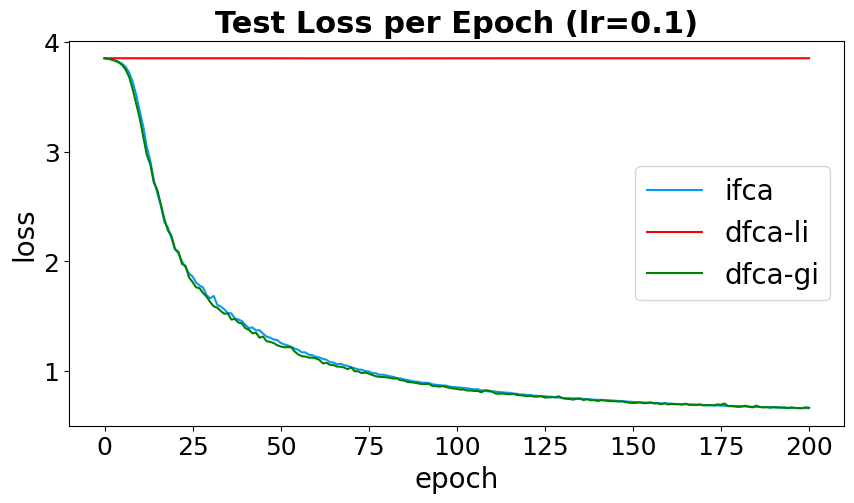

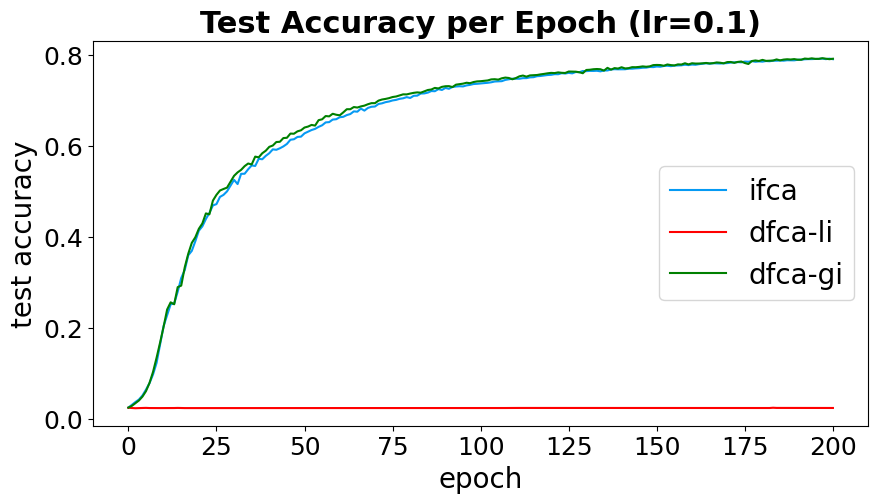

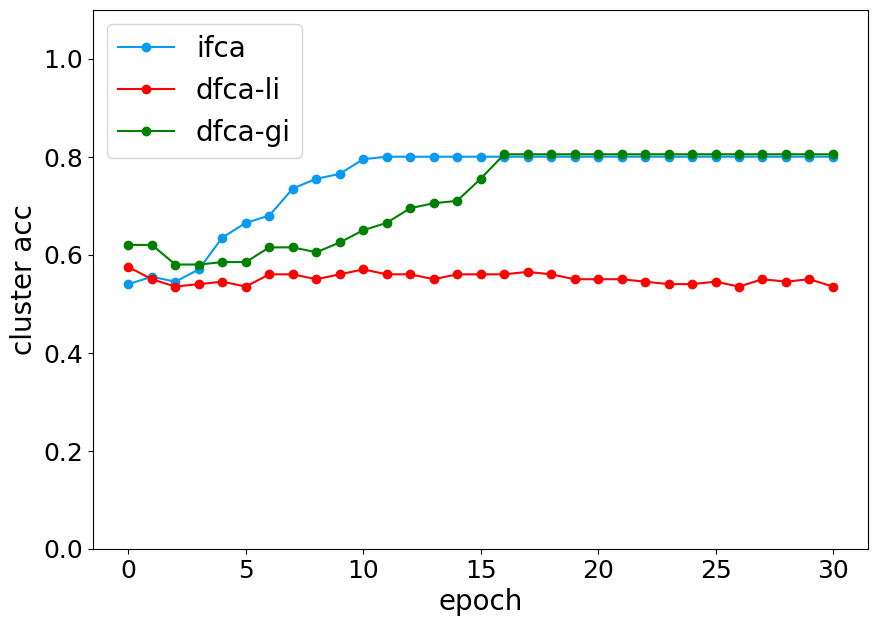

In [11]:

r_ifca = {}
r_dfca_gi = {}
r_dfca_li = {}

r_ifca['test_loss'] = []
r_ifca['test_acc'] = []
r_ifca['cl_acc'] = []
for i in range(len(learning_rates)):
    r_ifca['test_loss'].append(ifca[i][0])
    r_ifca['test_acc'].append(ifca[i][1])
    r_ifca['cl_acc'].append(ifca[i][2])

r_dfca_gi['test_loss'] = []
r_dfca_gi['test_acc'] = []
r_dfca_gi['cl_acc'] = []
for i in range(len(learning_rates)):
    r_dfca_gi['test_loss'].append(dfca_gi[i][0])
    r_dfca_gi['test_acc'].append(dfca_gi[i][1])
    r_dfca_gi['cl_acc'].append(dfca_gi[i][2])

r_dfca_li['test_loss'] = []
r_dfca_li['test_acc'] = []
r_dfca_li['cl_acc'] = []
for i in range(len(learning_rates)):
    r_dfca_li['test_loss'].append(dfca_li[i][0])
    r_dfca_li['test_acc'].append(dfca_li[i][1])
    r_dfca_li['cl_acc'].append(dfca_li[i][2])

print(r_ifca)

os.makedirs('graphs', exist_ok=True)

for l in range(len(learning_rates)):

    plt.figure(figsize=(10,5))
    plt.plot(r_ifca['test_loss'][l], label='ifca', color='xkcd:azure')
    plt.plot(r_dfca_li['test_loss'][l], label='dfca-li', color='red')
    plt.plot(r_dfca_gi['test_loss'][l], label='dfca-gi', color='green')
    plt.xlabel('epoch', fontsize=20)
    plt.ylabel('loss', fontsize=20)
    plt.title(f'Test Loss per Epoch (lr={learning_rates[l]})', fontsize=22, fontweight='bold')
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.legend(fontsize=20)
    plt.savefig(os.path.join('graphs', 'train_loss.png'))

    plt.figure(figsize=(10,5))
    plt.plot(r_ifca['test_acc'][l], label='ifca', color='xkcd:azure')
    plt.plot(r_dfca_li['test_acc'][l], label='dfca-li', color='red')
    plt.plot(r_dfca_gi['test_acc'][l], label='dfca-gi', color='green')
    plt.xlabel('epoch', fontsize=20)
    plt.ylabel('test accuracy', fontsize=20)
    plt.title(f'Test Accuracy per Epoch (lr={learning_rates[l]})', fontsize=22, fontweight='bold')
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.legend(fontsize=20)
    plt.savefig(os.path.join('graphs', 'test_acc.png'))

    plt.figure(figsize=(10,7))
    plt.ylim([0, 1.1])
    plt.plot(r_ifca['cl_acc'][l][:31], label='ifca', color='xkcd:azure', marker='o')
    plt.plot(r_dfca_li['cl_acc'][l][:31], label='dfca-li', color='red', marker='o')
    plt.plot(r_dfca_gi['cl_acc'][l][:31], label='dfca-gi', color='green', marker='o')
    plt.xlabel('epoch', fontsize=20)
    plt.ylabel('cluster acc', fontsize=20)
    plt.legend(fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.savefig(os.path.join('graphs', 'cluster_acc.png'))